In [1]:
# importing the libraries

import pyspiel
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt


from open_spiel.python import policy
from open_spiel.python import rl_environment
from open_spiel.python.algorithms import exploitability
from open_spiel.python.algorithms import policy_gradient

from open_spiel.python.algorithms import mcts
from open_spiel.python.algorithms.alpha_zero import evaluator as evaluator_lib
from open_spiel.python.algorithms.alpha_zero import model as model_lib

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# here we build the model
def build_model(game, model_type, nn_width, nn_depth, learning_rate, weight_decay, model_saves_path):
    return model_lib.Model.build_model(
      model_type, game.observation_tensor_shape(), game.num_distinct_actions(),
      nn_width=nn_width, nn_depth=nn_depth, weight_decay=weight_decay, learning_rate=learning_rate, path=model_saves_path)

# load our best model
def load_model(iteration):
    
    game_name = "connect_four"
    model_saves_path = '../model_saves/connect_four'
    nn_width = 10
    nn_depth = 5
    learning_rate = 0.001
    weight_decay = 0.0001
    model_type = 'mlp'

    game = pyspiel.load_game(game_name)
    
    new_model = build_model(game, model_type, nn_width, nn_depth, learning_rate, weight_decay, model_saves_path)
    new_model.load_checkpoint(f"../model_saves/connect_four/checkpoint-{iteration}")
    return new_model

# initialize the mcts bot
def initialize_bot(game, model, uct_c, max_simulations, policy_epsilon, policy_alpha):
    
    az_evaluator = evaluator_lib.AlphaZeroEvaluator(game, model)

    bot = mcts.MCTSBot(
          game,
          uct_c,
          max_simulations,
          az_evaluator,
          solve=False,
          dirichlet_noise=None,
          child_selection_fn=mcts.SearchNode.puct_value,
          verbose=False)
    
    return bot

In [3]:
# load the game
game = pyspiel.load_game("connect_four")

# load our trained model
model = load_model(13)

# RL environment configurations for policy gradient
num_players = 2
env_configs = {"players": num_players}
env = rl_environment.Environment(game, **env_configs)
info_state_size = env.observation_spec()["info_state"][0]
num_actions = env.action_spec()["num_actions"]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Restoring parameters from ../model_saves/connect_four/checkpoint-13


In [4]:
# Number of train episodes for policy gradient 
num_episodes = 100000

In [5]:
with tf.Session() as sess:
    
    # make the policy gradient agent
    agents = [
              policy_gradient.PolicyGradient(
              sess,
              player_id=player_id,
              info_state_size=info_state_size,
              num_actions=num_actions,
              loss_str="qpg",
              hidden_layers_sizes=[50, 50, 50, 50, 50],
              batch_size=32,
              entropy_cost=0.001,
              critic_learning_rate=0.01,
              pi_learning_rate=0.01,
              num_critic_before_pi=4) for player_id in [0, 1]
      ]
    sess.run(tf.global_variables_initializer())
    for ep in range(num_episodes):

        time_step = env.reset()
        while not time_step.last():
            player_id = time_step.observations["current_player"]
            agent_output = agents[player_id].step(time_step)
            action_list = [agent_output.action]
            time_step = env.step(action_list)

      # Episode is over, step all agents with final info state.
        for agent in agents:
            agent.step(time_step)
    
    
    # compare our alphazero model with trained policy bot
    track_wins = []
    track_lost = []
    n_evaluations = 100
    for j in range(10):
        wins = 0
        for i in range(n_evaluations):
            state = game.new_initial_state()
            mcts_bot = initialize_bot(game, model, 2, 25, None, None)

            # select the first policy bot to play against alphazero bot
            policy_bot = agents[0]
            while not state.is_terminal():
                actions = []
                temperature = 1
                temperature_drop = 10

                # if current turn is of alphazero bot
                if state.current_player() == 0:
                    root = mcts_bot.mcts_search(state)
                    policy = np.zeros(game.num_distinct_actions())
                    for c in root.children:
                        policy[c.action] = c.explore_count
                    policy = policy ** (1 / temperature)
                    policy /= policy.sum()
                    if len(actions) >= temperature_drop:
                        action = root.best_child().action
                    else:
                        action = np.random.choice(len(policy), p=policy)

                # if the turn is of policy bot
                else:
                    action, probs = policy_bot._act(state.observation_tensor(), state.legal_actions())

                state.apply_action(action)

            # if alphazero bot wins
            if (state.returns()[0] == 1):
                wins += 1

        print(f"Win Rate of AlphaZero: {wins/n_evaluations * 100}%")
        track_wins.append(wins/n_evaluations * 100)
        track_lost.append((n_evaluations - wins)/n_evaluations * 100)

Win Rate of AlphaZero: 80.0%
Win Rate of AlphaZero: 74.0%
Win Rate of AlphaZero: 71.0%
Win Rate of AlphaZero: 76.0%
Win Rate of AlphaZero: 67.0%
Win Rate of AlphaZero: 69.0%
Win Rate of AlphaZero: 68.0%
Win Rate of AlphaZero: 74.0%
Win Rate of AlphaZero: 64.0%
Win Rate of AlphaZero: 76.0%


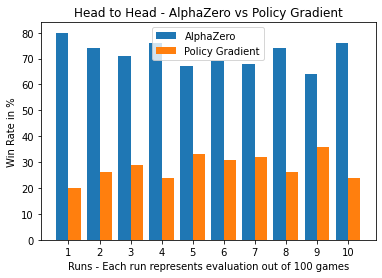

In [6]:
#plots
w = 0.4
bar1 = np.arange(1, 10 + 1)
bar2 = [i + w for i in bar1]
plt.bar(bar1, track_wins, w, label="AlphaZero")
plt.bar(bar2, track_lost, w, label="Policy Gradient")
plt.xticks(bar1+w/2, bar1)
plt.xlabel("Runs - Each run represents evaluation out of 100 games")
plt.ylabel("Win Rate in %")
plt.title("Head to Head - AlphaZero vs Policy Gradient")
plt.legend()
plt.show()